# Sheet 05

* all the variouse modules and packages that might be required for this sheet

In [31]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
import scipy
from scipy.stats import skew
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

### particles in a reflective Box

* first off we need to simulate

In [32]:
class Particles:
    """
    Container for all particles of a simulation with the same attributes and interactions.

    Fields:

        n: (int)
                -> Number of particles 

        m: (float)
                -> Mass of the paricles

        d: (int)
                -> Dimension in which the particles live

        r: (float)
                -> Radius of particles

        x: (NDArray[np.flaot64, shape=(d,n)]),
                -> Array of positions vectors; All positions

        v: (NDArray[np.flaot64, shape=(d,n)])
                -> Array of velocity vectors; All velocities

        a: (NDArray[np.flaot64, shape=d,n])
                -> Array of acceleration vectors; All accelerations
    """
    def __init__(
        self,
        number: int,
        mass: float | int,
        radius: float | int,
        dimensions: int = 2
    ):
        """
        Initiate particles with unpecified positions, velocities, accelerations.
        """
        # constants
        self.n: int = number
        self.m: float = float(mass)
        self.d: int = dimensions
        self.r: float = radius

        self.x: NDArray[np.float64]= np.zeros((dimensions,number))
        self.v: NDArray[np.float64]= np.zeros((dimensions,number))

In [33]:
class Ensemble(Particles):
    def __init__(self, number, mass, radius, ensemble_size,dimensions = 2):
        super().__init__(number, mass, radius, dimensions*ensemble_size)

### initiating particles on a grid

In [ ]:
def initiate_positions_on_grid(
        number_of_particles: int,
        box: tuple[float|int, float|int]
) -> None:
    """
    Initializes 2D positions on a Grid with even spacing.

    Parameters:
                
        n_particles:(int)
                -> number of particles

        box:(tuple[number,number]) 
                -> box size (in [nm])

    Return:

        (NDArray[float, shpae=(dimension, number of particles)])
                -> list of vectors of positons that are aranged on a grid
    """
    grid_sections = int(np.ceil(np.sqrt(number_of_particles)))+1  # find the number of colums & rows

    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    # makes grid coordinates
    x, y= np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )
    positions= np.array([x.flatten()[:number_of_particles]+x_spacing/2, y.flatten()[:number_of_particles]+y_spacing/2])
    print("init positions\n",positions)  
    return positions

In [35]:
def initiate_velocities(
        n_particles: int,
        dimension:int,
        velocity: float
) -> NDArray[np.float64]:
    """
    Initiating random velocities.
    """
    velocities=  (np.random.rand(dimension,n_particles) - 0.5)
    velocities= velocity/np.linalg.norm(velocities) * velocities
    print("init velocities\n", velocities)
    return velocities

* boundry conditions: reflecting

In [ ]:
def reflecting_boundry_conditions(
        particles :Particles,
        box: tuple[float|int,float|int]
        ) -> None:
    """
    Reflecs particles on the boundries given by the box.

    Parameters:

        particle: (Particle)
                -> particles of the simulation

        box: (tuple[number, number])
                -> box in which the particles are kept 
    """
    for dim in range(particles.d):
            particles.v[dim, :] = np.where(
                    particles.x[dim, :]-particles.r <0,
                    -particles.v[dim, :],
                    particles.v[dim, :]
                )
            particles.v[dim, :] = np.where(
                    particles.x[dim, :] + particles.r> box[1],
                    -particles.v[dim, :],
                    particles.v[dim, :]
                )
    pass



### Iterations and Simulation

In [37]:
def iterate(
        particles: Particles,
        box: tuple,
        dt:float
):
    """
    Tterates the particles with elastic collision.
    """
    for i in range(particles.n):
        reflecting_boundry_conditions(particles=particles, box=box) 

        for j in range(i,particles.n):
            r_rel= particles.x[:,i]-particles.x[:,j]
            d_rel= np.linalg.norm(r_rel)
            
            if d_rel-particles.r <= 0 and d_rel!=0:
                r_pro= r_rel/d_rel
                dv= np.dot((particles.v[:,i]-particles.v[:,j]),r_pro) * r_pro
                particles.v[:,i] -= dv
                particles.v[:,j] += dv
        particles.x+= particles.v*dt                   

In [38]:
def simulate(
        particles:Particles,
        box: tuple,
        Time_steps:int,
        dt:float,
        data: NDArray[np.float32]
) -> None:
        """
        Simulates the trajectory of hard spheres & elastic collision.
        """
        data= np.zeros((Time_steps, particles.d, particles.n))
        for t in range(Time_steps):
                iterate(particles=particles,box=box,dt=dt)
                data[t,:,:]=particles.x

In [ ]:
def simulate_ensemble(
        num_particle: int,
        box: tuple,
        dt: float,
        time_steps: int,
        mass: float,
        velocity: float,
        radius: float,
        ensemble_size: int,
)-> NDArray[np.float32]:
    """
    Simulates an ensemble of simulations of the same kind in a for loop.

    Return: 

        data: (NDArray[float, shape=(ensemble_size, time_steps, dims, num_particle)])
    """
    ensemble: list[Particles]= [Particles(number=num_particle,mass=mass,radius=radius,dimensions=len(box)) for i in range(ensemble_size)]  # generate an array of independant simulations   
    print("Ensemble size:", len(ensemble))

    e=0
    data= np.zeros(((ensemble_size, time_steps, len(box), num_particle)))
    for p in ensemble:
        print("\n\n")
        p.x= initiate_positions_on_grid(number_of_particles=p.n,box=(box[0]/2,box[1]))
        p.v= initiate_velocities(n_particles=p.n, dimension=p.d, velocity=velocity)
        simulate(particles=p,box=box, Time_steps=time_steps, dt=dt, data=data[e])
        e+=1
    return data

### Animations for debugging

In [40]:
def animate(
        frame,
        x_data: NDArray[np.float64],
        y_data: NDArray[np.float64], 
        scat
):
    """
    Takes x and y data [time, particle]; init funciton for "creat_animation"
    """
    positions = np.c_[x_data[frame, :], y_data[frame,:]]
    scat.set_offsets(positions)
    return scat,

def animation_plot(
    p_radius: float|int,
    box: tuple[float|int]
):
    """
    takes box size and particle radius. Initation for "creat_animation"
    """
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    return scat, fig, ax

def creat_animation(
        animation_box: tuple[int,int],
        particle_drawn_radius: float|int,
        x_data: NDArray[np.float64],
        y_data: NDArray[np.float64],
        save_animation: bool= False,
        animation_name: str= "partilce_simulation",
) -> FuncAnimation: 
    """
    x- and y_data has the form of [time, paritcle]. \n
    Saves the animation if save_animation = True.
    """
    scat, fig, ax = animation_plot(p_radius=particle_drawn_radius, box=animation_box)
    anim = FuncAnimation(fig, animate, frames=len(x_data[:,0]), fargs=(x_data, y_data, scat), interval=20, blit=True)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    if save_animation:
        anim.save(animation_name+".mp4")
    return anim

Ensemble size: 5



init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[ 0.11047385 -0.11413443 -0.14940431  0.20501648 -0.22046437]
 [-0.05939156  0.07096295 -0.00399914  0.06781667  0.31405847]]



init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[-0.03141683 -0.09097421  0.26462576  0.2357727   0.22055972]
 [-0.21728762 -0.05655272 -0.11507711 -0.05269389  0.0065588 ]]



init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[-0.04235837 -0.13792007  0.20907026 -0.20074028  0.0261235 ]
 [ 0.21287397  0.04264235  0.19820141 -0.15658575  0.18318777]]



init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[-0.16494497  0.06040058  0.09751472 -0.14217383 -0.1275023 ]
 [ 0.2115609   0.19344067 -0.1869299  -0.22278657  0.0800726 ]]



init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.2

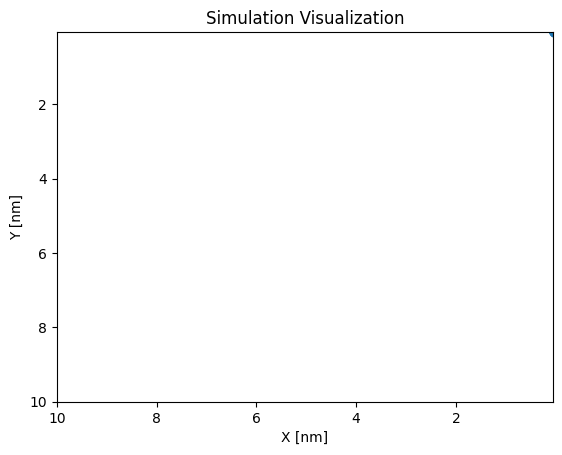

In [ ]:
BOX = (10,10)  # [nm]
RADIUS=0.2   # radius of hard spheres in [nm]
MASS= 18*10**(-3)   #  [kg/mol]
K_B= 1.380649*10**(-23)  # [J/K]

NUM: NDArray= np.array([5,25,50]) # number of particles
ENS: NDArray= np.array([5,25,50])

DT = 1  #  integration step size [ns]
TIME_STEPS = 300
VELOCITY= 0.5/DT  # velocity [nm/ns]



data= simulate_ensemble(
        num_particle=NUM[0],
        box=BOX,
        dt=DT,
        time_steps=TIME_STEPS,
        mass=MASS,
        velocity=VELOCITY,
        radius=RADIUS,
        ensemble_size=ENS[0]
)
mp4=creat_animation(BOX,100,data[0,:,0,:],data[0,:,1,:] )
HTML(mp4.to_html5_video())

Ensemble size: 5
init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[-0.01614047  0.17763749  0.2102252  -0.02832256  0.17243882]
 [-0.00724766 -0.11820439  0.21588496 -0.13923682  0.25186195]]
init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[ 0.28350852 -0.01753143 -0.28299441 -0.08720532  0.07645233]
 [-0.10300712 -0.04476115  0.14641077  0.09408151  0.1813244 ]]
init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[-0.12998111  0.11894887  0.09944648  0.18769803 -0.16171796]
 [-0.14287352  0.24368791 -0.19545306  0.13851743  0.10245783]]
init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  3.75 ]]
init velocities
 [[ 0.21437562 -0.1044447  -0.04206655 -0.15968822 -0.23329899]
 [ 0.06454258  0.18505111 -0.12439727 -0.18691436  0.15038198]]
init positions
 [[0.625 1.875 3.125 4.375 0.625]
 [1.25  1.25  1.25  1.25  

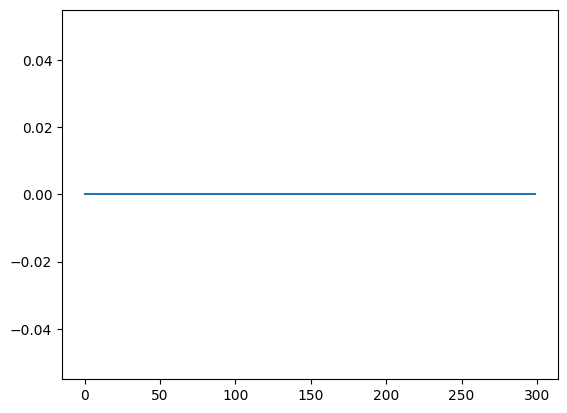

In [ ]:
def left_right_counting(ensemble_data, box):
    """
    determines the entropy for the variable <<left or right>>
    """HTML(mp4.to_html5_video())
    right_t=np.zeros(len(ensemble_data[0,:,0,0]))
    for t in range(len(ensemble_data[0,:,0,0])):
        right_t[t] = np.sum(np.where(ensemble_data[:,t,0,:] > box[0]/2, 1,0))
    return right_t, right_t-len(ensemble_data[0,:,0,0])

l,r=left_right_counting(simulate_ensemble(
        num_particle=NUM[0],
        box=BOX,
        dt=DT,
        time_steps=TIME_STEPS,
        mass=MASS,
        velocity=VELOCITY,
        radius=RADIUS,
        ensemble_size=ENS[0]
),box=BOX)

plt.plot(np.arange(len(l)),l)
plt.show()
plt.close()